# Project Overview
---------

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

 
Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.


|Variable|Description|
|---|---|
|Item_Identifier|Unique product ID|
|Item_Weight|Weight of product|
|Item_Fat_Content|Whether the product is low fat or not|
|Item_Visibility|The % of total display area of all products in a store allocated to the particular product|
|Item_Type|The category to which the product belongs|
|Item_MRP|Maximum Retail Price (list price) of the product|
|Outlet_Identifier|Unique store ID|
|Outlet_Establishment_Year|The year in which store was established|
|Outlet_Size|The size of the store in terms of ground area covered|
|Outlet_Location_Type|The type of city in which the store is located|
|Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket|
|Item_Outlet_Sales|Sales of the product in the particulat store. This is the outcome variable to be predicted.|

Root Mean Square Error (RMSE) will be used to measure performance.

# Setup

In [359]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
sns.set()

# Where to save the figures
PROJECT_ROOT_DIR = "."
#CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Import Data

In [360]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/dorond/big-mart-sales-prediction/master/"
STORES_PATH = os.path.join("datasets")
STORES_URL = DOWNLOAD_ROOT + "datasets/stores.tgz"

def fetch_store_data(stores_url=STORES_URL, stores_path=STORES_PATH):
    if not os.path.isdir(stores_path):
        os.makedirs(stores_path)
    tgz_path = os.path.join(stores_path, "stores.tgz")
    urllib.request.urlretrieve(stores_url, tgz_path)
    stores_tgz = tarfile.open(tgz_path)
    stores_tgz.extractall(path=stores_path)
    stores_tgz.close()

In [361]:
fetch_store_data()

In [362]:
import pandas as pd

def load_stores_training_data(stores_path=STORES_PATH):
    csv_path = os.path.join(stores_path, "train.csv")
    return pd.read_csv(csv_path)

def load_stores_test_data(stores_path=STORES_PATH):
    csv_path = os.path.join(stores_path, "test.csv")
    return pd.read_csv(csv_path)

def load_stores_sample_data(stores_path=STORES_PATH):
    csv_path = os.path.join(stores_path, "sample_submission.csv")
    return pd.read_csv(csv_path)

In [363]:
train = load_stores_training_data()
test = load_stores_test_data()
sample = load_stores_sample_data()

In [364]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [365]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [366]:
sample.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,NaN
1,FDW14,OUT017,NaN
2,NCN55,OUT010,NaN
3,FDQ58,OUT017,NaN
4,FDY38,OUT027,NaN


## Preliminary Investigation

In [367]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [368]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
Item_Identifier              5681 non-null object
Item_Weight                  4705 non-null float64
Item_Fat_Content             5681 non-null object
Item_Visibility              5681 non-null float64
Item_Type                    5681 non-null object
Item_MRP                     5681 non-null float64
Outlet_Identifier            5681 non-null object
Outlet_Establishment_Year    5681 non-null int64
Outlet_Size                  4075 non-null object
Outlet_Location_Type         5681 non-null object
Outlet_Type                  5681 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


- Item_weight and Outlet_size have missing values.

In [369]:
train["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

- Different spellings of similar categories > Low Fat & LF & low fat; Regular & reg. Let's fix these straight away in both the training and test sets.

In [370]:
train["Item_Fat_Content"].where((train["Item_Fat_Content"] == "Low Fat") | (train["Item_Fat_Content"] == "Regular") | 
                                (train["Item_Fat_Content"] == "reg"), "Low Fat", inplace=True)
train["Item_Fat_Content"].where((train["Item_Fat_Content"] == "Regular") | (train["Item_Fat_Content"] == "Low Fat"), "Regular", inplace=True)
train["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [371]:
test["Item_Fat_Content"].where((test["Item_Fat_Content"] == "Low Fat") | (test["Item_Fat_Content"] == "Regular") | 
                                (test["Item_Fat_Content"] == "reg"), "Low Fat", inplace=True)
test["Item_Fat_Content"].where((test["Item_Fat_Content"] == "Regular") | (test["Item_Fat_Content"] == "Low Fat"), "Regular", inplace=True)
test["Item_Fat_Content"].value_counts()

Low Fat    3668
Regular    2013
Name: Item_Fat_Content, dtype: int64

In [372]:
train["Item_Type"].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

- Might be useful to add a column to group drinks and food together

In [373]:
train["Outlet_Size"].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [374]:
train["Outlet_Location_Type"].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [375]:
train["Outlet_Type"].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [376]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Saving figure attribute_histogram_plots


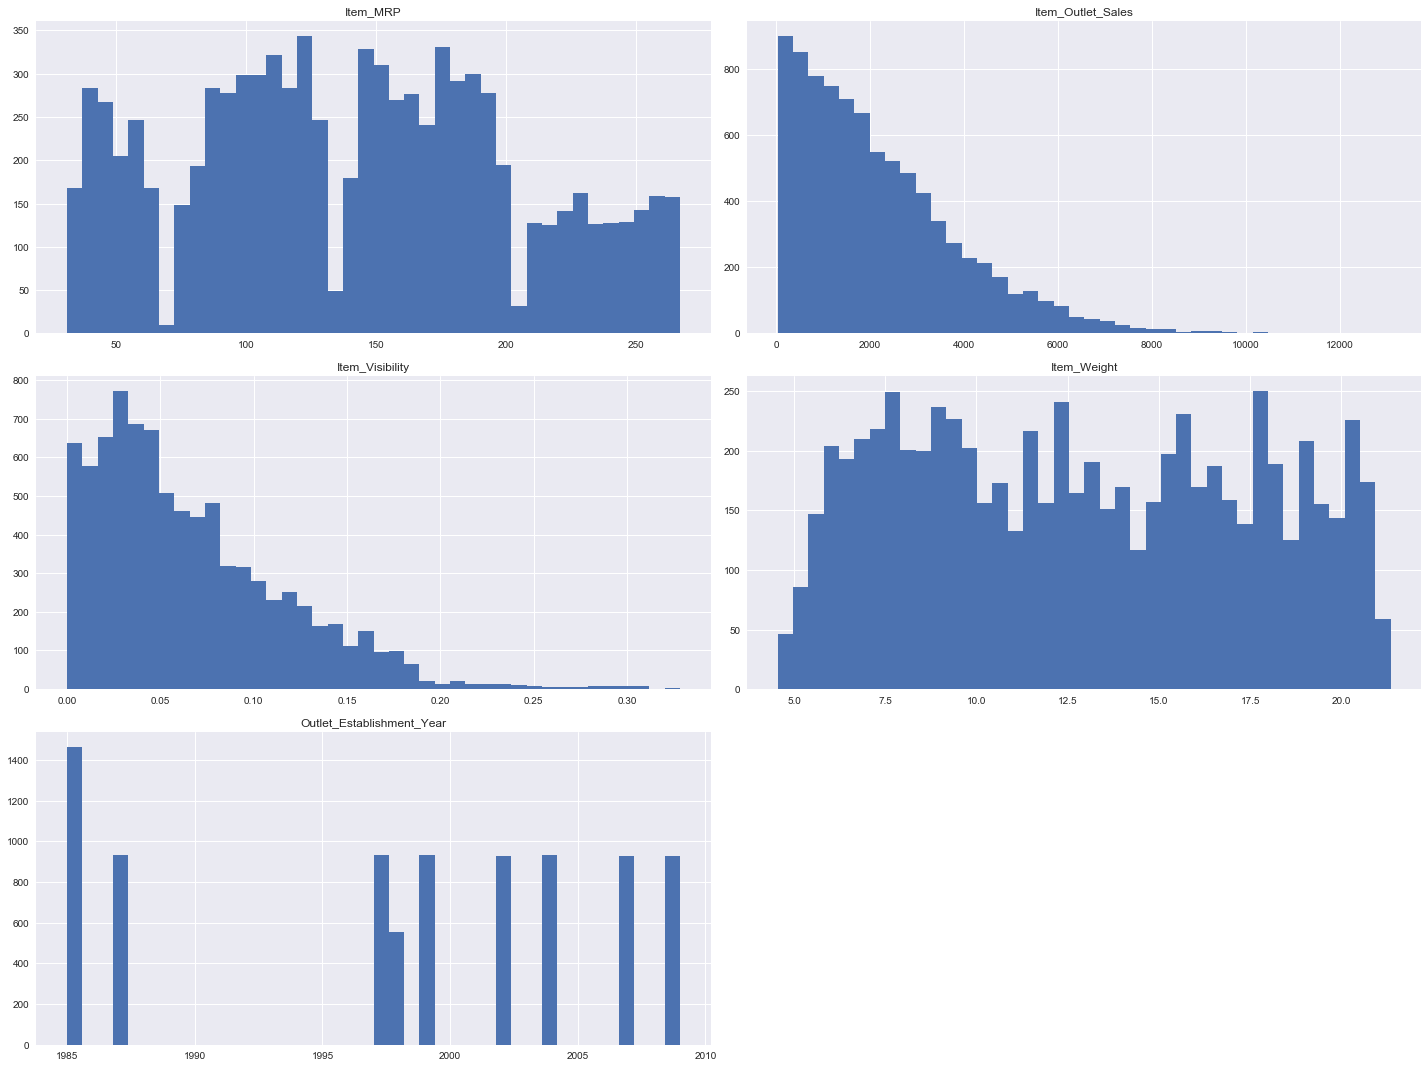

In [377]:
train.hist(bins=40, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

- Few distinct categories of pricing, might be useful to add a price range column. 
- Period of 10 years where no new stores where created, with more being establish in 1985. Buisiness seemed to scale from around 1997. 
- Most itms have less than 10% visibility. Need to correlate sales with visibility, do more visible items have more sales volume?
- Weight seems to be fairly uniformly distributed across all product types, as expected. 

In [378]:
# to make this notebook's output identical at every run
np.random.seed(42)

## Creating Stratified Training and Validation Sets
We must ensure that the 80% sample of data we use for the training set is representative of the full dataset. To do this, we'll understand a few proportions within the data before constructing a 80% training set and 20% test set. 

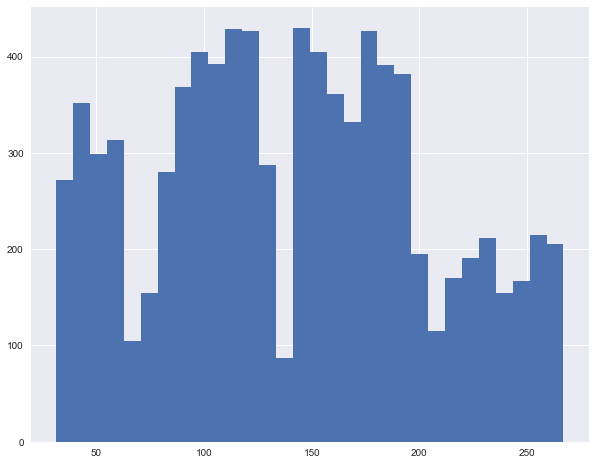

In [379]:
# We previously identified different product price ranges, it might be useful to ensure similar splits exist within the final training set. 
train["Item_MRP"].hist(figsize=(10,8), bins=30)

In [380]:
price_cat = np.ceil(train["Item_MRP"] / 70)
price_cat.value_counts()

3.0    3042
2.0    2778
4.0    1362
1.0    1341
Name: Item_MRP, dtype: int64

In [381]:
# Divide by 70 to limit the number of price range categories
train["price_cat"] = np.ceil(train["Item_MRP"] / 70)

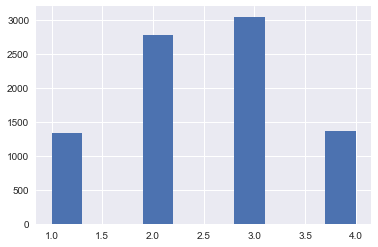

In [382]:
train["price_cat"].hist()

In [383]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train, train["price_cat"]):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

In [384]:
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

3.0    0.357185
2.0    0.326100
4.0    0.159531
1.0    0.157185
Name: price_cat, dtype: float64

In [385]:
train["price_cat"].value_counts() / len(train)

3.0    0.356917
2.0    0.325942
4.0    0.159803
1.0    0.157339
Name: price_cat, dtype: float64

In [386]:
from sklearn.model_selection import train_test_split

def price_cat_proportions(data):
    return data["price_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(train),
    "Stratified": price_cat_proportions(strat_test_set),
    "Random": price_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [387]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.157339,0.157185,0.161877,2.884135,-0.098014
2.0,0.325942,0.326100,0.354839,8.865742,0.048517
3.0,0.356917,0.357185,0.340762,-4.526020,0.075136
4.0,0.159803,0.159531,0.142522,-10.813880,-0.170269


In [388]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

# Discover & Visualise Data

## Understanding Numerical Relationships

In [389]:
# Ensuring we have a clean copy of training data from which to perform an EDA.
sales = strat_train_set.copy()

In [390]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
251,FDL20,17.10,Low Fat,0.128938,Fruits and Vegetables,112.3886,OUT018,2009,Medium,Tier 3,Supermarket Type2,1779.0176
5943,FDM58,16.85,Regular,0.079624,Snack Foods,111.6544,OUT013,1987,High,Tier 3,Supermarket Type1,2125.2336
4778,FDT09,15.15,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,NaN,Tier 2,Supermarket Type1,3559.3668
8432,FDI16,14.00,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920
4889,FDP01,20.75,Regular,0.063314,Breakfast,153.7682,OUT035,2004,Small,Tier 2,Supermarket Type1,1829.6184


### Exploring Distributions 

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Saving figure sales_listing_price_kds_hist


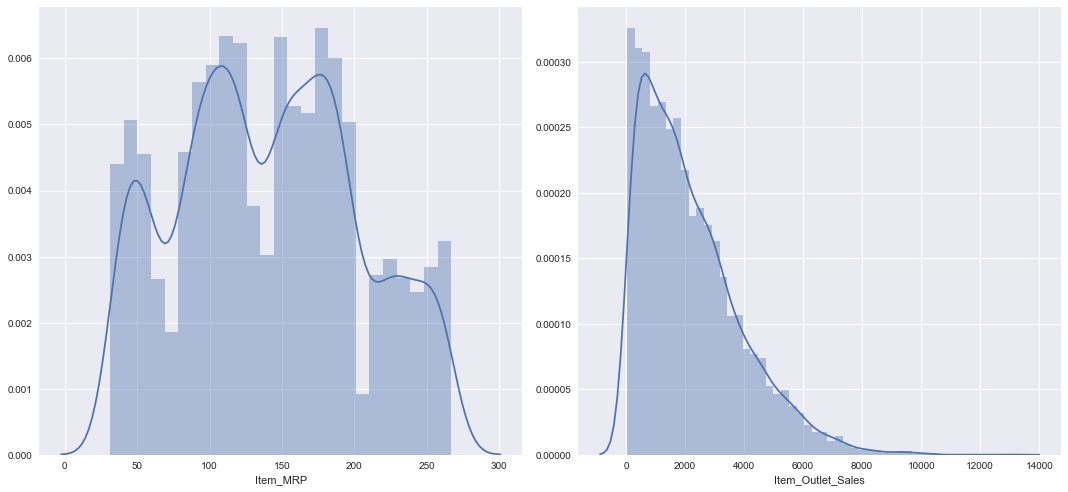

In [391]:
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.distplot(sales['Item_MRP'])
fig.add_subplot(122)
sns.distplot(sales['Item_Outlet_Sales'])
save_fig("sales_listing_price_kds_hist")

Saving figure sales_by_item_type_box_plot


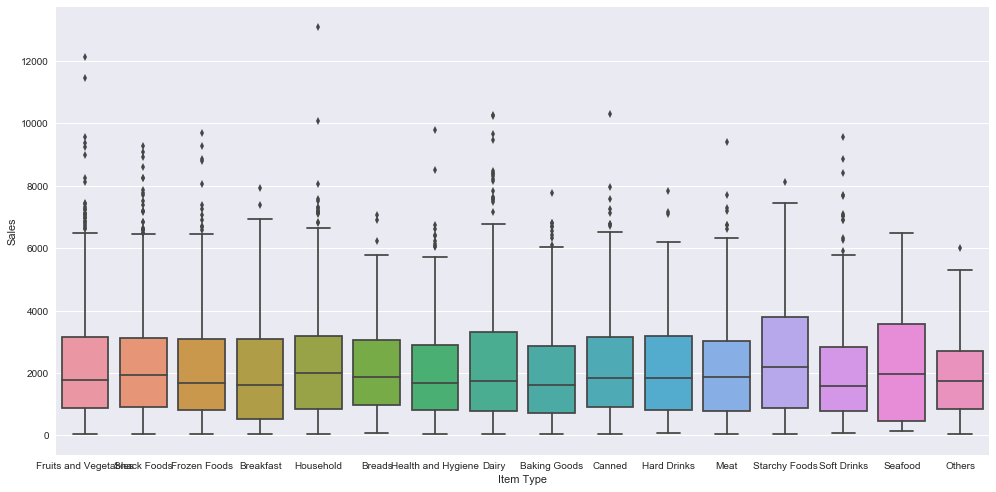

In [392]:
g = sns.factorplot("Item_Type", "Item_Outlet_Sales", data=sales, kind="box", size=7, aspect=2)
g.set_axis_labels("Item Type", "Sales")
g.set_titles("Sales by Item Type Box Plot")
save_fig("sales_by_item_type_box_plot")

Saving figure list_price_by_outlet_type_box_plot


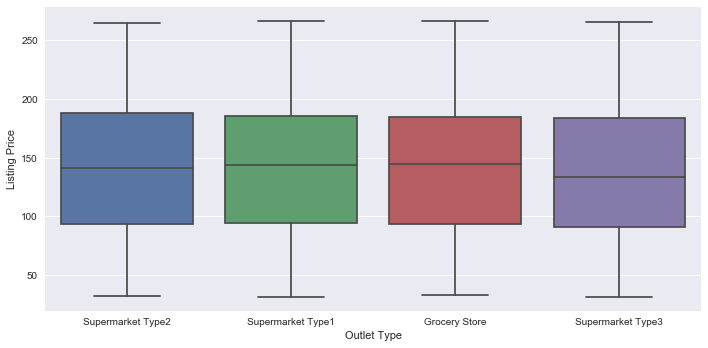

In [393]:
g = sns.factorplot("Outlet_Type", "Item_MRP", data=sales, kind="box", size=5, aspect=2)
g.set_axis_labels("Outlet Type", "Listing Price")
g.set_titles("Listing Price by Outlet Type Box Plot")
save_fig("list_price_by_outlet_type_box_plot")

### Exploring Correlations

In [394]:
corr_matrix = sales.corr()

In [395]:
corr_matrix["Item_Outlet_Sales"].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.566739
Item_Weight                  0.019046
Outlet_Establishment_Year   -0.043774
Item_Visibility             -0.128151
Name: Item_Outlet_Sales, dtype: float64

Saving figure sales_correlation_bar_plot


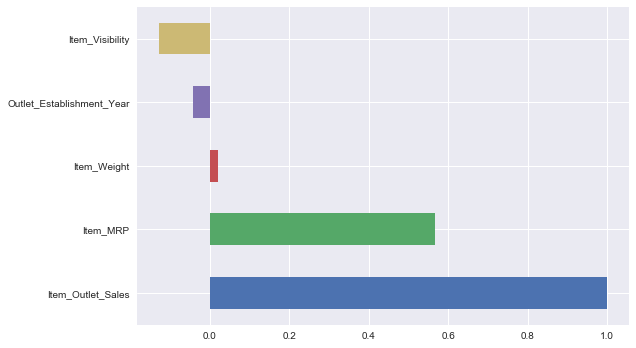

In [396]:
corr_matrix["Item_Outlet_Sales"].sort_values(ascending=False).plot.barh(figsize=(9, 5))
save_fig("sales_correlation_bar_plot")

- Item visibility has a small negative correlation with sales, could be due to outliers though. 

Saving figure scatter_matrix_plot


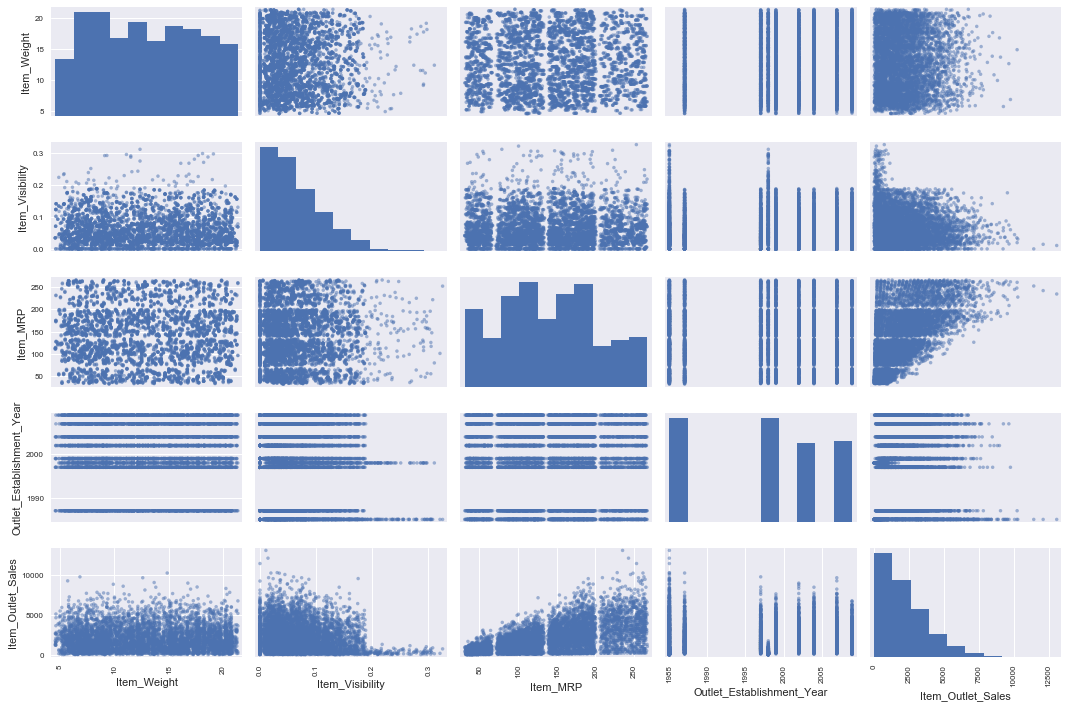

In [397]:
from pandas.plotting import scatter_matrix

scatter_matrix(sales, figsize=(15, 10))
save_fig("scatter_matrix_plot")

Saving figure price_vs_sales_scatterplot


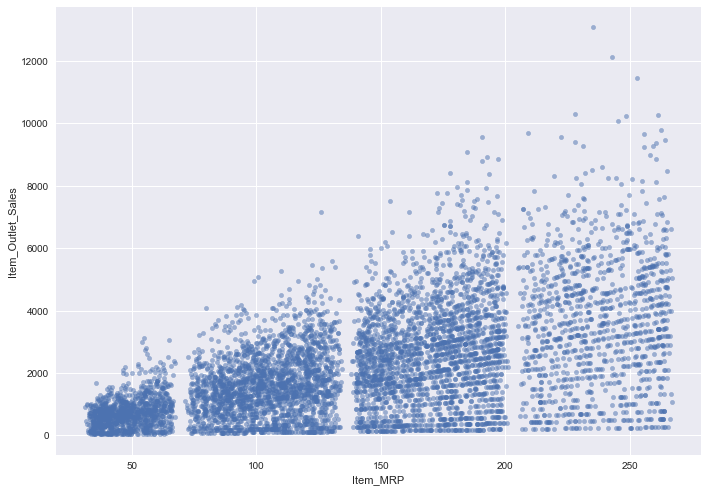

In [398]:
sales.plot(kind="scatter", x="Item_MRP", y="Item_Outlet_Sales",
             alpha=0.5, figsize=(10, 7))
#plt.axis([0, 16, 0, 550000])
save_fig("price_vs_sales_scatterplot")

- We identified 4 distinct pricing categories. In addition it seems there are discrete cutoff points between each.
- While there are generally 2000 worth of sales across all price categories, it seems that as the price points increase, so do the sales. 

Saving figure visibility_vs_sales_scatterplot


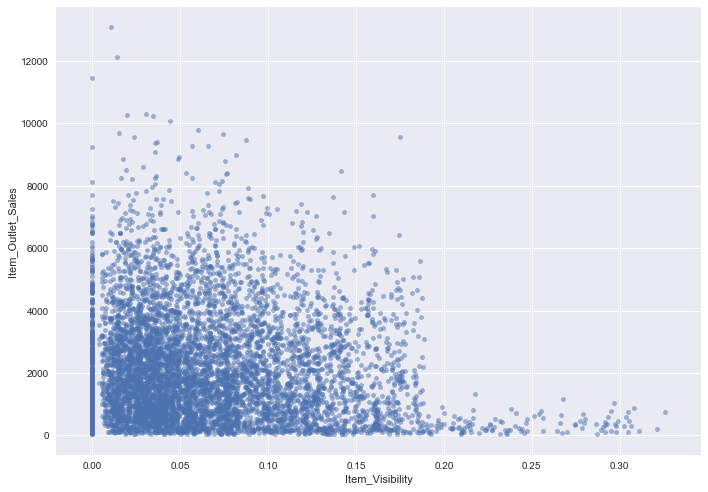

In [399]:
sales.plot(kind="scatter", x="Item_Visibility", y="Item_Outlet_Sales",
             alpha=0.5, figsize=(10, 7))
#plt.axis([0, 16, 0, 550000])
save_fig("visibility_vs_sales_scatterplot")

- Some outliers have almost no visibility but a large amount of sales. 
- It seems as visibility goes beyond 20%, sales diminish. 
- A number of sales are generated from items with 0 visibility, must be explored.

### Investigating Outliers

In [400]:
zero_vis_sales = sales[(sales["Item_Visibility"] == 0)]
zero_vis_sales

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8404,DRH39,NaN,Low Fat,0.0,Dairy,75.9670,OUT019,1985,Small,Tier 1,Grocery Store,153.1340
1972,NCO02,11.150,Low Fat,0.0,Others,65.0142,OUT049,1999,Medium,Tier 1,Supermarket Type1,1120.5414
968,NCO17,10.000,Low Fat,0.0,Health and Hygiene,120.6440,OUT035,2004,Small,Tier 2,Supermarket Type1,1917.5040
1346,FDN12,15.600,Low Fat,0.0,Baking Goods,111.8544,OUT018,2009,Medium,Tier 3,Supermarket Type2,1454.1072
6938,FDY33,14.500,Regular,0.0,Snack Foods,159.3262,OUT035,2004,Small,Tier 2,Supermarket Type1,2864.2716
3687,DRK37,5.000,Low Fat,0.0,Soft Drinks,189.8530,OUT045,2002,NaN,Tier 2,Supermarket Type1,4933.5780
623,FDY59,8.195,Low Fat,0.0,Baking Goods,93.1462,OUT018,2009,Medium,Tier 3,Supermarket Type2,647.8234
500,NCK54,12.150,Low Fat,0.0,Household,117.8150,OUT017,2007,NaN,Tier 2,Supermarket Type1,2330.3000
7102,FDQ39,14.800,Low Fat,0.0,Meat,189.3846,OUT013,1987,High,Tier 3,Supermarket Type1,4777.1150
6093,FDE21,NaN,Low Fat,0.0,Fruits and Vegetables,115.3492,OUT027,1985,Medium,Tier 3,Supermarket Type3,3823.0236


Saving figure zero_visibility_sales_by_fat_content


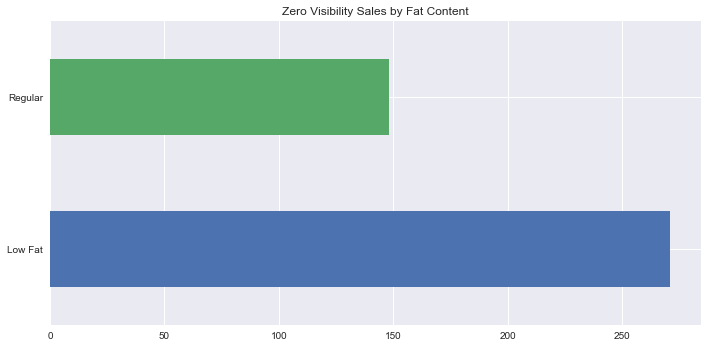

In [401]:
zero_vis_sales["Item_Fat_Content"].value_counts().plot.barh(figsize=(10, 5), title='Zero Visibility Sales by Fat Content')
save_fig("zero_visibility_sales_by_fat_content")

Saving figure zero_visibility_sales_by_item_type


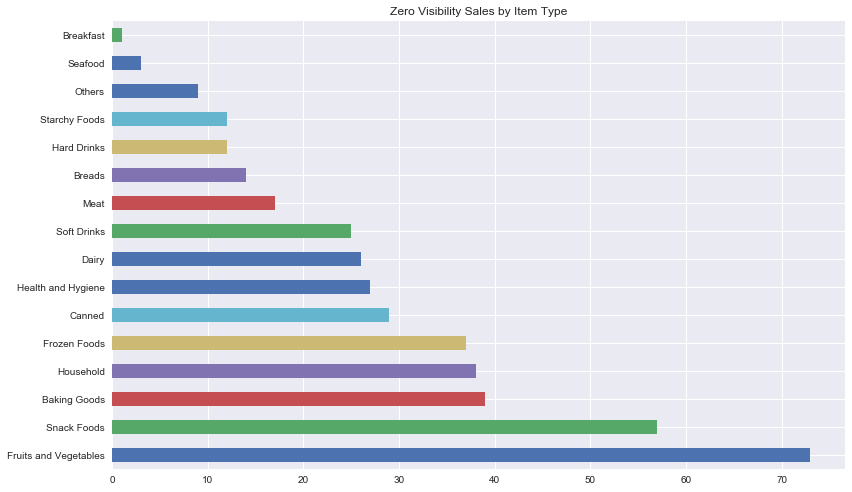

In [402]:
zero_vis_sales["Item_Type"].value_counts().plot.barh(figsize=(12, 7), title='Zero Visibility Sales by Item Type')
save_fig("zero_visibility_sales_by_item_type")

Saving figure zero_visibility_sales_by_outlet


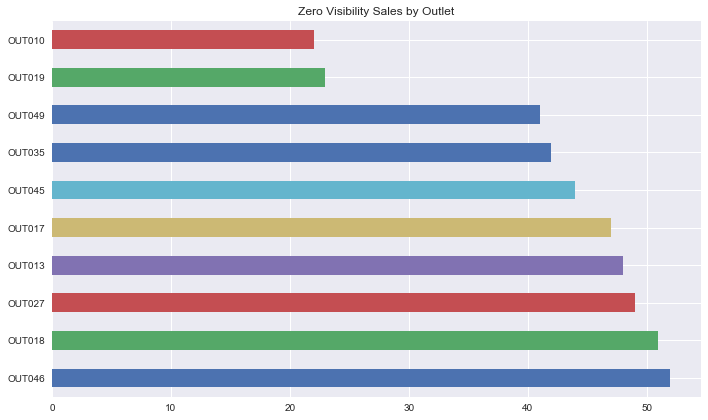

In [403]:
zero_vis_sales["Outlet_Identifier"].value_counts().plot.barh(figsize=(10, 6), title='Zero Visibility Sales by Outlet')
save_fig("zero_visibility_sales_by_outlet")

Saving figure zero_visibility_sales_by_outlet_size


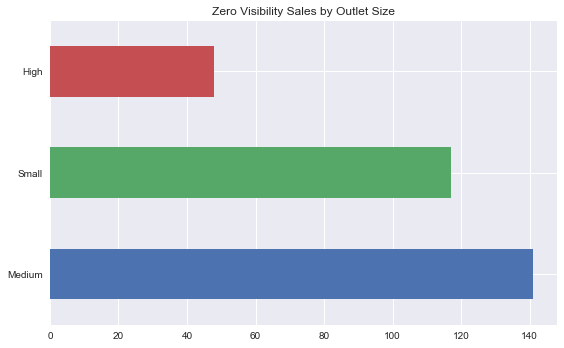

In [404]:
zero_vis_sales["Outlet_Size"].value_counts().plot.barh(figsize=(8, 5), title='Zero Visibility Sales by Outlet Size')
save_fig("zero_visibility_sales_by_outlet_size")

Saving figure zero_visibility_sales_by_item_type


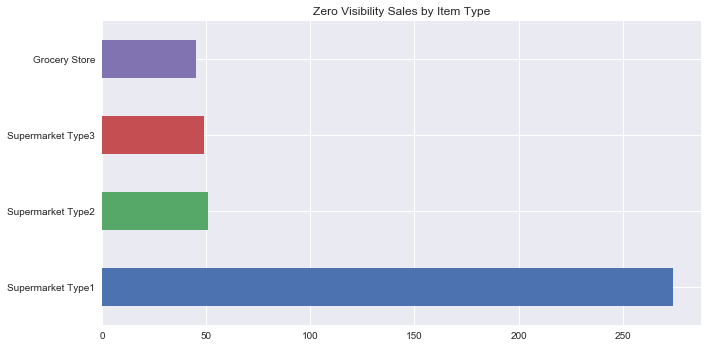

In [405]:
zero_vis_sales["Outlet_Type"].value_counts().plot.barh(figsize=(10, 5), title='Zero Visibility Sales by Item Type')
save_fig("zero_visibility_sales_by_item_type")

- The highest amount of items with zero visibility seems to be coming from Type 1 Medium Supermarkets, fruit & vegetables products marked as low fat. 

In [406]:
low_vis_high_sales = sales[(sales["Item_Visibility"] < 0.02) & (sales["Item_Outlet_Sales"] > 11000)]
low_vis_high_sales

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1450,FDZ20,NaN,Low Fat,0.000000,Fruits and Vegetables,253.0356,OUT027,1985,Medium,Tier 3,Supermarket Type3,11445.1020
5223,FDQ19,NaN,Regular,0.014296,Fruits and Vegetables,242.6512,OUT027,1985,Medium,Tier 3,Supermarket Type3,12117.5600
7188,NCE42,NaN,Low Fat,0.010551,Household,234.9958,OUT027,1985,Medium,Tier 3,Supermarket Type3,13086.9648


- All the items with low visibility but high sales are from the same store and don't have a weight specified. 
- OUT27 also had a lot of items with zero visibility specified. 

In [407]:
high_vis_low_sales = sales[(sales["Item_Visibility"] > 0.19) & (sales["Item_Outlet_Sales"] < 2000)]
high_vis_low_sales

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8432,FDI16,14.000,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920
7949,FDK25,NaN,Regular,0.274592,Breakfast,167.8474,OUT019,1985,Small,Tier 1,Grocery Store,336.8948
847,FDL56,NaN,Low Fat,0.220226,Fruits and Vegetables,85.6198,OUT019,1985,Small,Tier 1,Grocery Store,87.2198
7072,FDL32,NaN,Regular,0.214424,Fruits and Vegetables,111.6544,OUT019,1985,Small,Tier 1,Grocery Store,335.5632
6909,FDC47,15.000,Low Fat,0.198999,Snack Foods,226.5694,OUT010,1998,NaN,Tier 3,Grocery Store,913.4776
49,FDS02,NaN,Regular,0.255395,Dairy,196.8794,OUT019,1985,Small,Tier 1,Grocery Store,780.3176
3767,FDN13,NaN,Low Fat,0.266234,Breakfast,98.5358,OUT019,1985,Small,Tier 1,Grocery Store,402.1432
4530,FDZ16,16.850,Regular,0.267566,Frozen Foods,194.1478,OUT010,1998,NaN,Tier 3,Grocery Store,1162.4868
7250,FDT24,12.350,Regular,0.311090,Baking Goods,79.2328,OUT010,1998,NaN,Tier 3,Grocery Store,154.4656
4350,FDN49,17.250,Regular,0.209600,Breakfast,40.3480,OUT010,1998,NaN,Tier 3,Grocery Store,39.9480


Saving figure high_visibility_low_sales_by_item_type


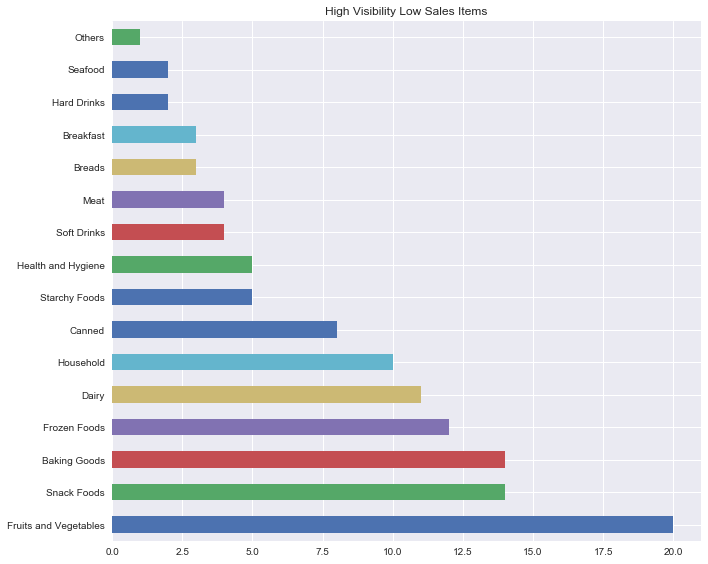

In [408]:
high_vis_low_sales["Item_Type"].value_counts().plot.barh(figsize=(10, 8), title="High Visibility Low Sales Items")
save_fig("high_visibility_low_sales_by_item_type")

In [409]:
high_vis_low_sales["Outlet_Type"].value_counts()

Grocery Store    118
Name: Outlet_Type, dtype: int64

- All the items with low visibility but high sales are from Grocery stores.

## Understanding Categorical Relationships

In [410]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
251,FDL20,17.10,Low Fat,0.128938,Fruits and Vegetables,112.3886,OUT018,2009,Medium,Tier 3,Supermarket Type2,1779.0176
5943,FDM58,16.85,Regular,0.079624,Snack Foods,111.6544,OUT013,1987,High,Tier 3,Supermarket Type1,2125.2336
4778,FDT09,15.15,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,NaN,Tier 2,Supermarket Type1,3559.3668
8432,FDI16,14.00,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920
4889,FDP01,20.75,Regular,0.063314,Breakfast,153.7682,OUT035,2004,Small,Tier 2,Supermarket Type1,1829.6184


### Sales by Item Type

In [411]:
sales_by_item_type = sales.groupby(["Item_Type"])['Item_Outlet_Sales'].sum()
sales_by_item_type

Item_Type
Baking Goods             1.026592e+06
Breads                   4.246506e+05
Breakfast                1.962679e+05
Canned                   1.185942e+06
Dairy                    1.240867e+06
Frozen Foods             1.438243e+06
Fruits and Vegetables    2.251777e+06
Hard Drinks              3.651920e+05
Health and Hygiene       8.415366e+05
Household                1.629266e+06
Meat                     7.136004e+05
Others                   2.670471e+05
Seafood                  1.138525e+05
Snack Foods              2.150829e+06
Soft Drinks              7.275822e+05
Starchy Foods            2.841435e+05
Name: Item_Outlet_Sales, dtype: float64

Saving figure total_sales_by_item_type


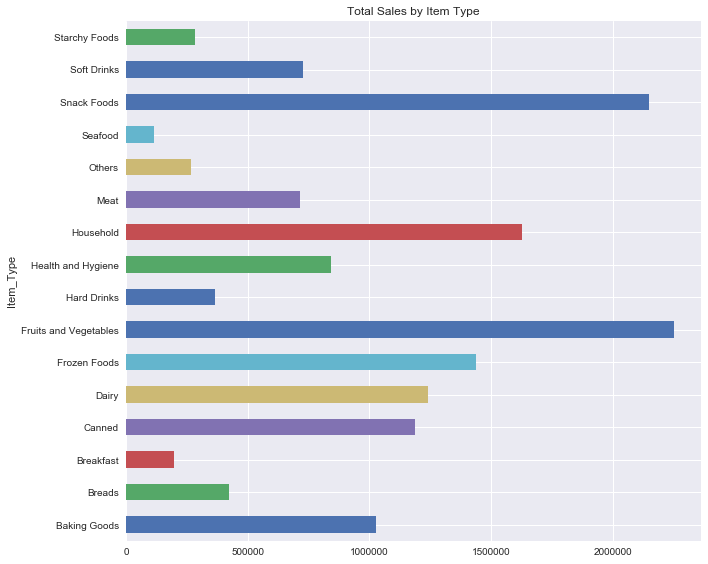

In [412]:
sales_by_item_type.plot.barh(figsize=(10,8), title="Total Sales by Item Type")
save_fig("total_sales_by_item_type")

### Sales by Item Type and Outlet Type

In [413]:
sales_by_item_type_outlet_type = sales.groupby(["Item_Type", "Outlet_Type"])['Item_Outlet_Sales'].sum().unstack().fillna(0)
sales_by_item_type_outlet_type

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Item_Type,,,,
Baking Goods,20476.6790,7.321803e+05,92490.2728,181445.1476
Breads,9722.0116,2.911204e+05,53636.1822,70171.9910
Breakfast,5920.9594,1.347246e+05,14917.2490,40705.0146
Canned,21366.8536,8.238496e+05,112679.9920,228045.8212
Dairy,24593.9862,8.629354e+05,134649.3946,218688.6680
Frozen Foods,27638.6896,1.004697e+06,135815.8762,270091.0912
Fruits and Vegetables,39687.6722,1.558447e+06,224291.3750,429351.1170
Hard Drinks,4762.4674,2.680877e+05,29582.1598,62759.6396
Health and Hygiene,19595.8256,5.843980e+05,82966.6696,154576.1228


Saving figure total_sales_by_item_type_and_outlet_type


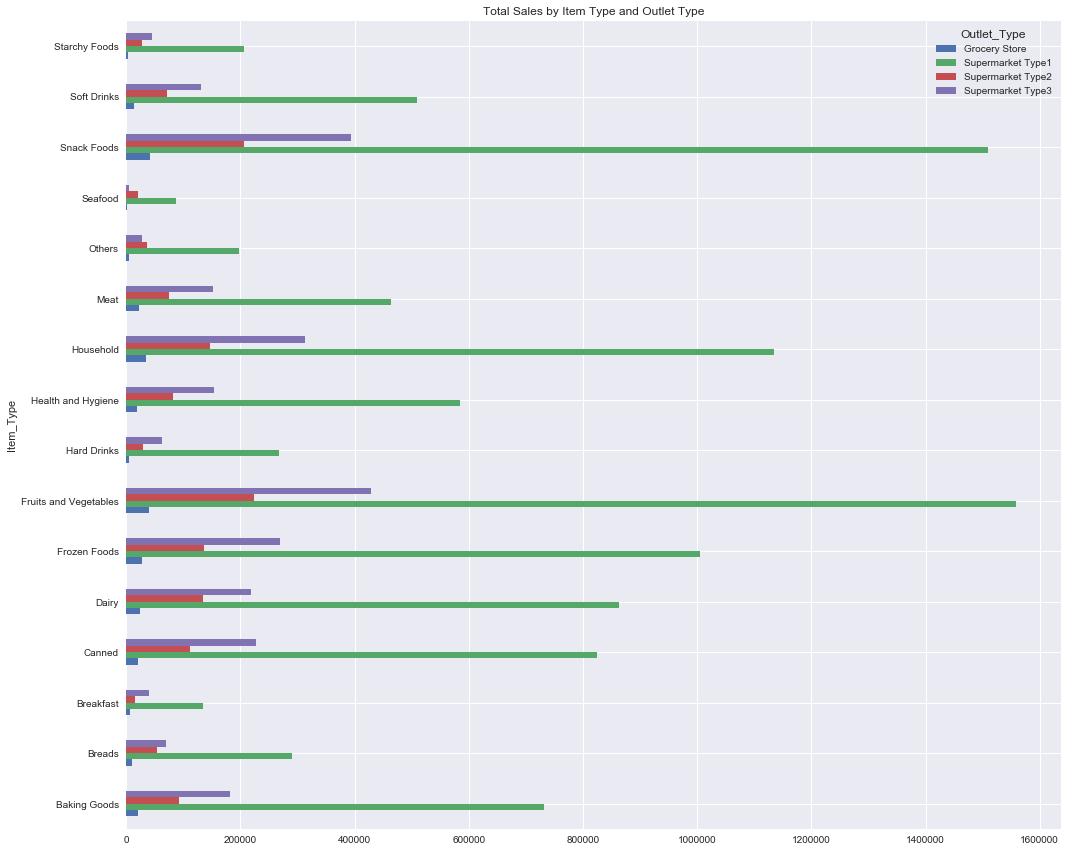

In [414]:
sales_by_item_type_outlet_type.plot.barh(figsize=(15,12), title="Total Sales by Item Type and Outlet Type")
save_fig("total_sales_by_item_type_and_outlet_type")

### Listing Price by Item Type

In [415]:
listing_price_by_item_type = sales.groupby(["Item_Type"])['Item_MRP'].median()#.unstack().fillna(0)
listing_price_by_item_type

Item_Type
Baking Goods             112.4544
Breads                   128.8310
Breakfast                155.3630
Canned                   140.1496
Dairy                    150.4708
Frozen Foods             127.2678
Fruits and Vegetables    145.4444
Hard Drinks              143.8128
Health and Hygiene       129.6468
Household                154.2814
Meat                     149.8366
Others                   127.5507
Seafood                  158.4604
Snack Foods              146.9076
Soft Drinks              143.9102
Starchy Foods            172.9593
Name: Item_MRP, dtype: float64

Saving figure median_listing_price_by_item_type


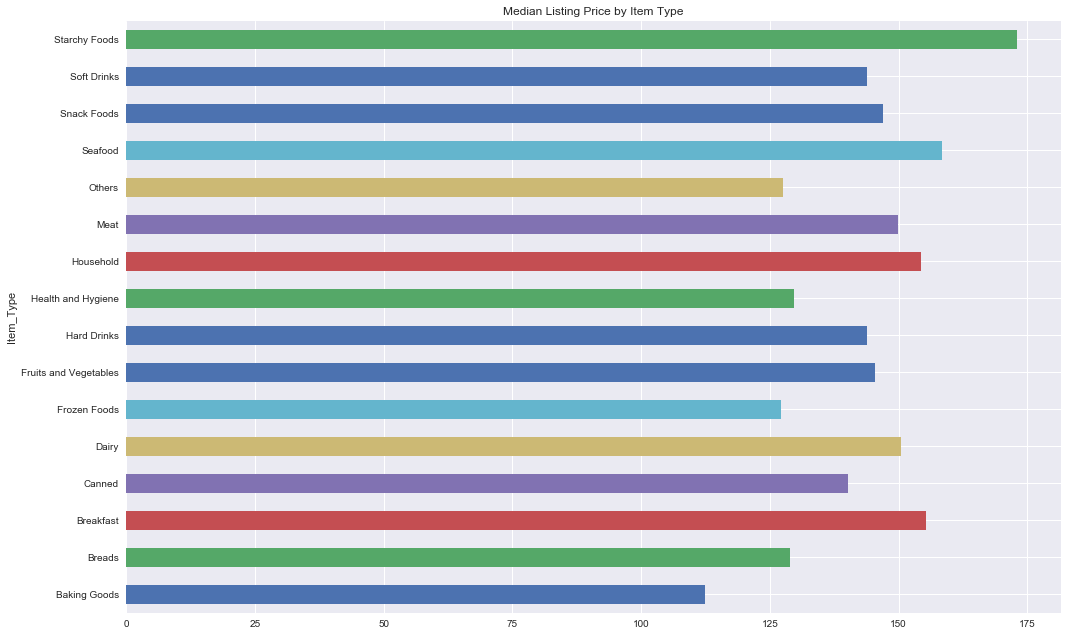

In [416]:
listing_price_by_item_type.plot.barh(figsize=(15,9), title="Median Listing Price by Item Type")
save_fig("median_listing_price_by_item_type")

### Listing Price by Item Type and Outlet Type

In [417]:
listing_price_by_item_type_outlet_type = sales.groupby(["Item_Type", "Outlet_Type"])['Item_MRP'].median().unstack().fillna(0)
listing_price_by_item_type_outlet_type

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Item_Type,,,,
Baking Goods,121.3098,110.5570,111.8544,121.5914
Breads,130.0152,130.3310,126.0678,110.1570
Breakfast,165.3500,151.7682,131.3310,169.3474
Canned,141.8838,138.6838,123.8046,153.4682
Dairy,147.1760,150.6708,155.4485,124.3704
Frozen Foods,126.9178,127.4020,126.4520,126.9336
Fruits and Vegetables,124.2388,147.6102,131.3126,146.0760
Hard Drinks,122.6585,136.5732,174.2080,165.7000
Health and Hygiene,140.7654,131.3310,114.4492,124.1072


Saving figure median_listing_price_by_item_type_outlet_type


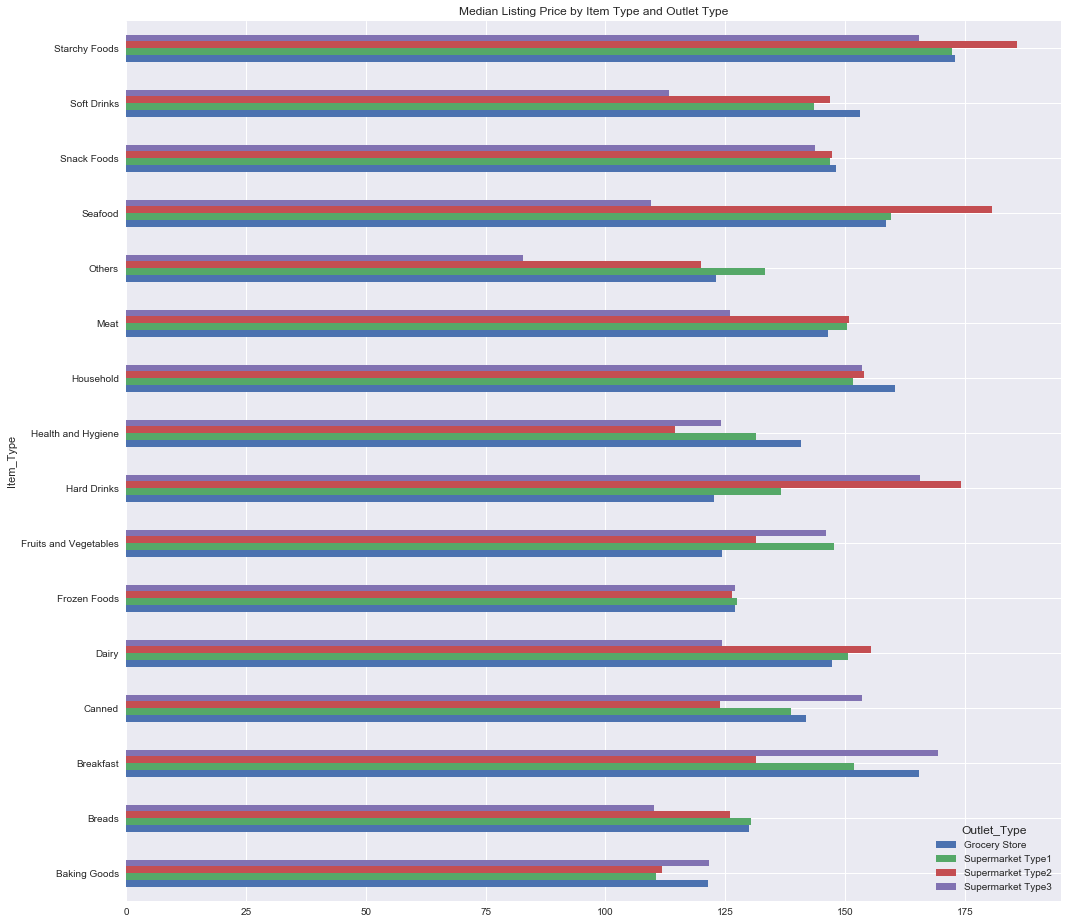

In [418]:
listing_price_by_item_type_outlet_type.plot.barh(figsize=(15,13), title="Median Listing Price by Item Type and Outlet Type")
save_fig("median_listing_price_by_item_type_outlet_type")

### Listing Price by Fat Content

In [419]:
listing_price_by_fat_content = sales.groupby(["Item_Fat_Content"])['Item_MRP'].median()#.unstack().fillna(0)
listing_price_by_fat_content

Item_Fat_Content
Low Fat    142.0154
Regular    144.2799
Name: Item_MRP, dtype: float64

Saving figure median_listing_price_by_fat_content


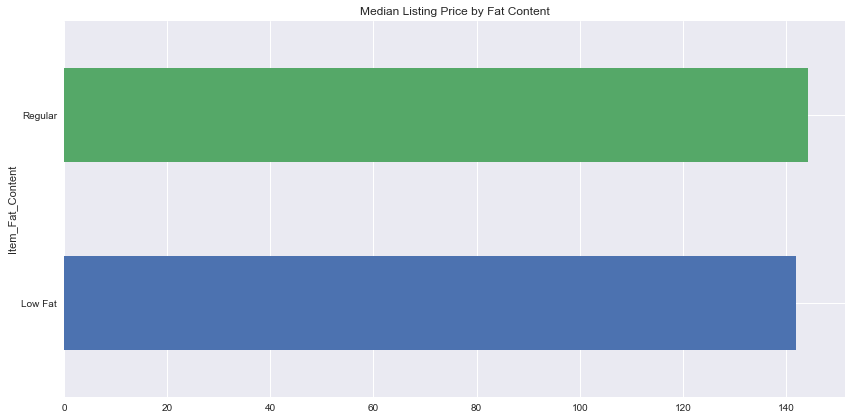

In [420]:
listing_price_by_fat_content.plot.barh(figsize=(12,6), title="Median Listing Price by Fat Content")
save_fig("median_listing_price_by_fat_content")

### Sales by Fat Content and Outlet Type

In [421]:
fat_content_sales = sales.groupby(["Item_Fat_Content", "Outlet_Type"])['Item_Outlet_Sales'].sum().unstack().fillna(0)
fat_content_sales

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Item_Fat_Content,,,,
Low Fat,187581.8262,6.637971e+06,933642.0188,1.735354e+06
Regular,109652.5994,3.731150e+06,533698.6220,9.883388e+05


Saving figure total_sales_by_fat_content_outlet_type


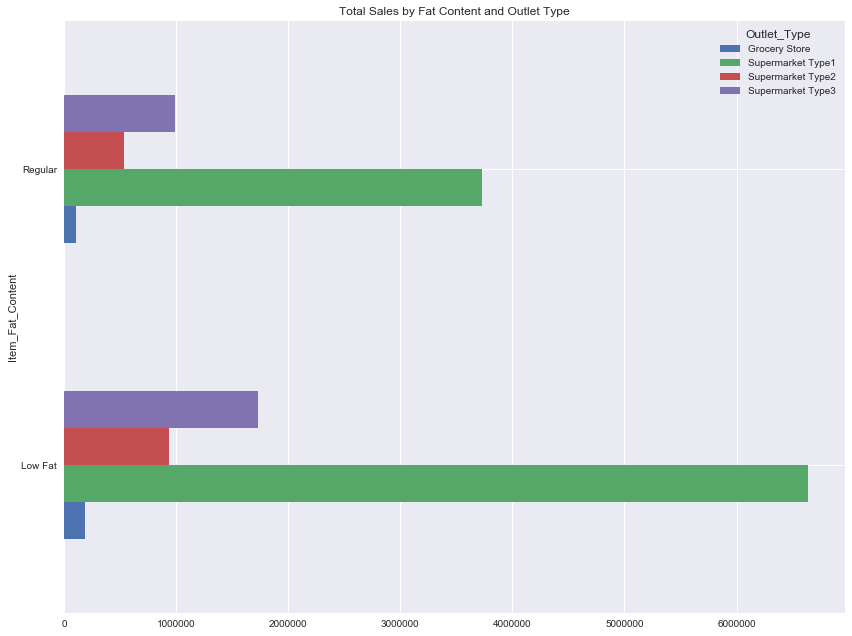

In [422]:
fat_content_sales.plot.barh(figsize=(12,9), title="Total Sales by Fat Content and Outlet Type")
save_fig("total_sales_by_fat_content_outlet_type")

### Sales by Outlet Type and Size

In [423]:
outlet_type_size_sales = sales.groupby(["Outlet_Type", "Outlet_Size"])['Item_Outlet_Sales'].sum().unstack().fillna(0)
outlet_type_size_sales

Outlet_Size,High,Medium,Small
Outlet_Type,,,
Grocery Store,0.000000e+00,0.000000e+00,146136.442
Supermarket Type1,1.722534e+06,1.784394e+06,3466271.315
Supermarket Type2,0.000000e+00,1.467341e+06,0.000
Supermarket Type3,0.000000e+00,2.723693e+06,0.000


Saving figure total_sales_by_outlet_type_outlet_size


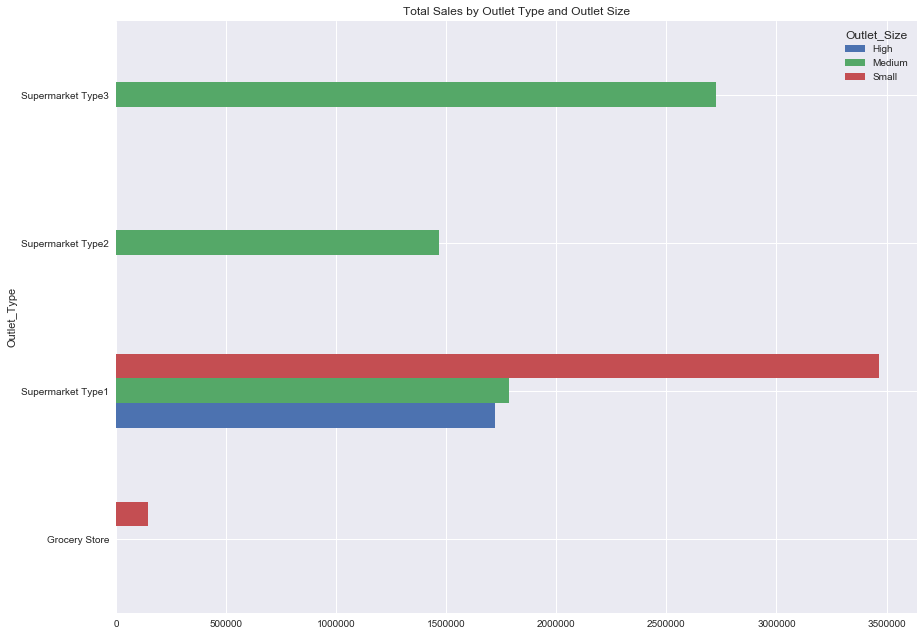

In [424]:
outlet_type_size_sales.plot.barh(figsize=(13,9), title="Total Sales by Outlet Type and Outlet Size")
save_fig("total_sales_by_outlet_type_outlet_size")

## Overall Observations

### General

- Item_weight and Outlet_size have missing values.
- Different spellings of similar categories > Low Fat & LF & low fat; Regular & reg. Will need to correct these.
- Might be useful to add a column to group drinks and food together.
- Period of 10 years where no new stores where created, with more being establish in 1985. Business seemed to scale from around 1997. 
- Weight seems to be fairly uniformly distributed across all product types, as expected. 
- While there are generally 2000 worth of sales across all price categories, it seems that as the price points increase, so do the sales.
- Listing price is has strongest positive correlation with sales, while item visibilty has a small negative correlation with sales. 
- It would be useful to plot sales by region and outlet type/size/location but we don't have geographic data.

### Sales

- Starchy foods and household products have a slightly higher median amount of sales. 
- Snack foods, fruit & veg and household products generate the highest sales.
- Fruit & veg, snack food and household product do best at type 1 supermarkets.
- Household products and fruit & veg sales have extreme outliers sales at a few stores. 
- Type 1, then type 3 supermarkets sell the most regular and low fat products. Grocery stores the least. 
- Type 1 supermarkets sell twice as much low fat products as regular fat. 

### Listing Price

- Four distinct pricing catgories, whose ratio has been maintained in stratified training sample. Might be useful to add a price range column. Seems there are discrete cutoff points between each price range.
- Median listing price of Supermarket Type 3 is slightly lower than the rest, which are all very similar. 
- Starchy foods, seafood and breakfast products have the highest median listing price, baking goods has the lowest. 
- Starchy foods, seafood and hard drinks have higher listing prices at type 1 supermarkets, while breakfast has its lowest listing price there. Breakfast product listing price is highest at type 3 supermarkets. 
- Fruit and vegetables highest listing price is at type 1 and 3 supermarkets. 
- Snack foods have a similar listing price across all outlet types. 
- Regaular and low fat products have similar median listing prices. 

### Visibility

- Low fat products with zero visibility sell better than regular fat products.
- Most items have less than 10% visibility. 
- Some outliers have almost no visibility but a large amount of sales.
- It seems as visibility goes beyond 20%, sales diminish.
- A number of sales are generated from items with 0 visibility. The highest amount of items with zero visibility seems to be coming from Type 1 Medium Supermarkets as well as fruit & vegetables, snack food and low fat products. 
- All the items with low visibility but high sales are from the same grocery store and don't have a weight specified.
- Fruits and vegetables tend to have high visibility but lower sales.

# Adding New Features
Based on the observations above, a few feeatures will be added to the dataset

In [425]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
251,FDL20,17.10,Low Fat,0.128938,Fruits and Vegetables,112.3886,OUT018,2009,Medium,Tier 3,Supermarket Type2,1779.0176
5943,FDM58,16.85,Regular,0.079624,Snack Foods,111.6544,OUT013,1987,High,Tier 3,Supermarket Type1,2125.2336
4778,FDT09,15.15,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,NaN,Tier 2,Supermarket Type1,3559.3668
8432,FDI16,14.00,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920
4889,FDP01,20.75,Regular,0.063314,Breakfast,153.7682,OUT035,2004,Small,Tier 2,Supermarket Type1,1829.6184


In [426]:
sales["mrp_per_visibility"] = sales["Item_MRP"] / sales["Item_Visibility"]
sales["mrp_per_weight"] = sales["Item_MRP"] / sales["Item_Weight"]
sales["visibility_per_weight"] = sales["Item_Visibility"] / sales["Item_Weight"]
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,mrp_per_visibility,mrp_per_weight,visibility_per_weight
251,FDL20,17.10,Low Fat,0.128938,Fruits and Vegetables,112.3886,OUT018,2009,Medium,Tier 3,Supermarket Type2,1779.0176,871.650681,6.572433,0.007540
5943,FDM58,16.85,Regular,0.079624,Snack Foods,111.6544,OUT013,1987,High,Tier 3,Supermarket Type1,2125.2336,1402.269140,6.626374,0.004725
4778,FDT09,15.15,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,NaN,Tier 2,Supermarket Type1,3559.3668,10543.412872,8.582733,0.000814
8432,FDI16,14.00,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920,239.214271,3.883143,0.016233
4889,FDP01,20.75,Regular,0.063314,Breakfast,153.7682,OUT035,2004,Small,Tier 2,Supermarket Type1,1829.6184,2428.661325,7.410516,0.003051


In [427]:
corr_matrix = sales.corr()
corr_matrix["Item_Outlet_Sales"].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.566739
mrp_per_weight               0.416447
mrp_per_visibility           0.276683
Item_Weight                  0.019046
Outlet_Establishment_Year   -0.043774
visibility_per_weight       -0.073759
Item_Visibility             -0.128151
Name: Item_Outlet_Sales, dtype: float64

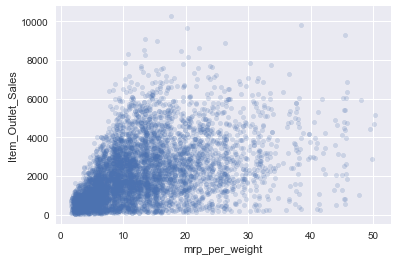

In [428]:
sales.plot(kind="scatter", x="mrp_per_weight", y="Item_Outlet_Sales", alpha=0.2)
plt.show()

## Observations on Correlation of New Features

- We were already aware that listing price MRP carries the most correlation and now it seems that the weight of an item is associated with its listing price, as expected, which in turn associates with sales. 

# Prepare Data for Machine Learning

There are a few tasks we'd like to automate into a pipeline, allowing us to easily tune our model later and try our different strategies.

In [429]:
# Ensuring we have a fresh training set without the target attribute. 
sales = strat_train_set.drop("Item_Outlet_Sales", axis=1) # drop labels for training set
sales_labels = strat_train_set["Item_Outlet_Sales"].copy()

## Handling Missing Values

In [430]:
sample_incomplete_rows = sales[sales.isnull().any(axis=1)]
sample_incomplete_rows.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4778,FDT09,15.150,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,NaN,Tier 2,Supermarket Type1
8432,FDI16,14.000,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store
4664,FDE41,9.195,Regular,0.064144,Frozen Foods,85.9566,OUT045,2002,NaN,Tier 2,Supermarket Type1
4501,NCU42,9.000,Low Fat,0.019617,Household,169.6474,OUT017,2007,NaN,Tier 2,Supermarket Type1
7976,FDX35,5.035,Regular,0.080073,Breads,228.2036,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [431]:
sales["Outlet_Size"].value_counts()

Medium    2260
Small     1878
High       749
Name: Outlet_Size, dtype: int64

- Item_Weight (numerical) and Outlet_Size (categorical) columns are missing values
- We want a way to try out different item weight metrics (mean, median, most frequent) in our eventual model. So rather than trying one at a time, across multiple combinations, we will build a pipeline that can try all of them on its own. This will add a lot of running time to the execution of the models, but will ensure we find the correct combinations.
- For the categorical missing values in Outlet_Size, we can either pick the most frequent value (Medium) and use that for all the missing entries, or see if we can manually visualise a better option. Will first try the visualisation, then go for the most frequent value if that doesn't yeild useful info.

Saving figure Outlet Size by Outlet Type and Location Type


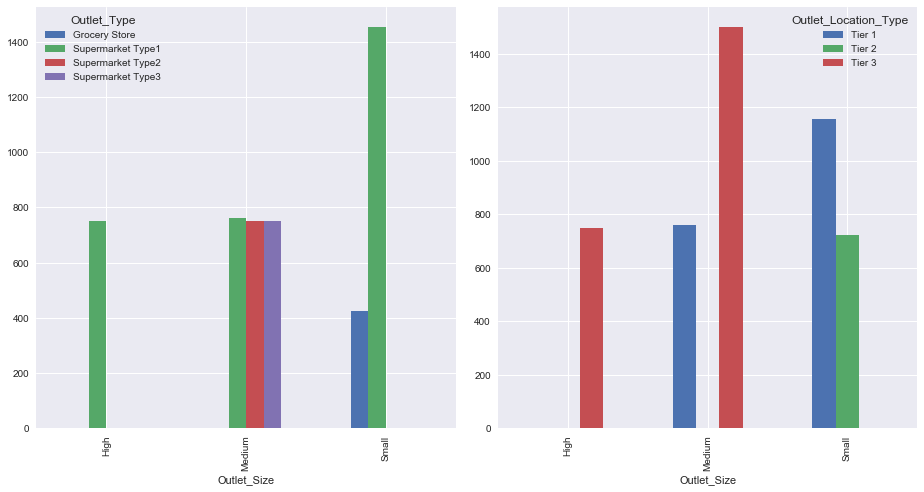

In [433]:
fig = plt.figure(figsize=(13,7))
ax1 = fig.add_subplot(121)
pd.crosstab(sales["Outlet_Size"], [sales["Outlet_Type"]]).plot.bar(ax=ax1)
ax2 = fig.add_subplot(122)
pd.crosstab(sales["Outlet_Size"], [sales["Outlet_Location_Type"]]).plot.bar(ax=ax2)
save_fig('Outlet Size by Outlet Type and Location Type')

- If it's a Grocery Store store, its always Small.
- If it's Tier 2, it's always Small. 
- If it's Type 2 or 3 supermarket, its always medium. 
- If it's a Tier 1 location or Type 1 Supermarket, it tends to be Small.
- If it's Tier 3 location, it tends to be Medium twice as often as High. 

The first three propositions are stronger than the last two. Let's apply this to add the missing Outlet Sizes:

In [434]:
row_filter = (pd.isnull(sales["Outlet_Size"])) & ((sales["Outlet_Type"] == "Grocery Store") | (sales["Outlet_Location_Type"] == "Tier 2"))
sales[row_filter]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4778,FDT09,15.150,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,NaN,Tier 2,Supermarket Type1
8432,FDI16,14.000,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store
4664,FDE41,9.195,Regular,0.064144,Frozen Foods,85.9566,OUT045,2002,NaN,Tier 2,Supermarket Type1
4501,NCU42,9.000,Low Fat,0.019617,Household,169.6474,OUT017,2007,NaN,Tier 2,Supermarket Type1
7976,FDX35,5.035,Regular,0.080073,Breads,228.2036,OUT045,2002,NaN,Tier 2,Supermarket Type1
2299,FDR02,16.700,Low Fat,0.022110,Dairy,110.8886,OUT045,2002,NaN,Tier 2,Supermarket Type1
5846,FDN12,15.600,Low Fat,0.081563,Baking Goods,112.7544,OUT017,2007,NaN,Tier 2,Supermarket Type1
8180,NCR05,10.100,Low Fat,0.054742,Health and Hygiene,200.2084,OUT045,2002,NaN,Tier 2,Supermarket Type1
5298,NCP05,19.600,Low Fat,0.025430,Health and Hygiene,151.7024,OUT017,2007,NaN,Tier 2,Supermarket Type1
8302,FDY20,12.500,Regular,0.082215,Fruits and Vegetables,91.4488,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [435]:
sales.loc[row_filter, 'Outlet_Size'] = "Small"

In [436]:
sales[row_filter]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4778,FDT09,15.150,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,Small,Tier 2,Supermarket Type1
8432,FDI16,14.000,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,Small,Tier 3,Grocery Store
4664,FDE41,9.195,Regular,0.064144,Frozen Foods,85.9566,OUT045,2002,Small,Tier 2,Supermarket Type1
4501,NCU42,9.000,Low Fat,0.019617,Household,169.6474,OUT017,2007,Small,Tier 2,Supermarket Type1
7976,FDX35,5.035,Regular,0.080073,Breads,228.2036,OUT045,2002,Small,Tier 2,Supermarket Type1
2299,FDR02,16.700,Low Fat,0.022110,Dairy,110.8886,OUT045,2002,Small,Tier 2,Supermarket Type1
5846,FDN12,15.600,Low Fat,0.081563,Baking Goods,112.7544,OUT017,2007,Small,Tier 2,Supermarket Type1
8180,NCR05,10.100,Low Fat,0.054742,Health and Hygiene,200.2084,OUT045,2002,Small,Tier 2,Supermarket Type1
5298,NCP05,19.600,Low Fat,0.025430,Health and Hygiene,151.7024,OUT017,2007,Small,Tier 2,Supermarket Type1
8302,FDY20,12.500,Regular,0.082215,Fruits and Vegetables,91.4488,OUT017,2007,Small,Tier 2,Supermarket Type1


In [437]:
sales["Outlet_Size"].value_counts()

Small     3809
Medium    2260
High       749
Name: Outlet_Size, dtype: int64

In [438]:
pd.isnull(sales["Outlet_Size"]).value_counts()

False    6818
Name: Outlet_Size, dtype: int64

We only needed to apply the first proposition in order to set all the missing values for Outlet_Type. Now we need to apply the same to the test set. 

In [439]:
sales_test = strat_test_set.drop("Item_Outlet_Sales", axis=1) # drop labels for testing set
sales_test_labels = strat_test_set["Item_Outlet_Sales"].copy()

In [440]:
row_filter = (pd.isnull(sales_test["Outlet_Size"])) & ((sales_test["Outlet_Type"] == "Grocery Store") | (sales_test["Outlet_Location_Type"] == "Tier 2"))
sales_test[row_filter]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1250,FDJ22,18.750,Low Fat,0.053109,Snack Foods,193.6504,OUT017,2007,NaN,Tier 2,Supermarket Type1
4987,FDR48,11.650,Low Fat,0.220111,Baking Goods,153.0024,OUT010,1998,NaN,Tier 3,Grocery Store
1151,FDK43,9.800,Low Fat,0.026993,Meat,127.3020,OUT017,2007,NaN,Tier 2,Supermarket Type1
693,FDR24,17.350,Regular,0.062979,Baking Goods,87.9830,OUT045,2002,NaN,Tier 2,Supermarket Type1
1162,FDU34,18.250,Low Fat,0.075620,Snack Foods,123.8046,OUT017,2007,NaN,Tier 2,Supermarket Type1
591,FDG14,9.000,Regular,0.050786,Canned,152.2024,OUT017,2007,NaN,Tier 2,Supermarket Type1
6422,NCM42,6.130,Low Fat,0.028482,Household,110.4912,OUT017,2007,NaN,Tier 2,Supermarket Type1
3609,FDC14,14.500,Regular,0.041482,Canned,40.0454,OUT017,2007,NaN,Tier 2,Supermarket Type1
483,FDC02,21.350,Low Fat,0.115195,Canned,258.3278,OUT010,1998,NaN,Tier 3,Grocery Store
4016,FDO40,17.100,Low Fat,0.054613,Frozen Foods,150.2392,OUT010,1998,NaN,Tier 3,Grocery Store


In [441]:
sales_test.loc[row_filter, 'Outlet_Size'] = "Small"

In [442]:
sales_test[row_filter]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1250,FDJ22,18.750,Low Fat,0.053109,Snack Foods,193.6504,OUT017,2007,Small,Tier 2,Supermarket Type1
4987,FDR48,11.650,Low Fat,0.220111,Baking Goods,153.0024,OUT010,1998,Small,Tier 3,Grocery Store
1151,FDK43,9.800,Low Fat,0.026993,Meat,127.3020,OUT017,2007,Small,Tier 2,Supermarket Type1
693,FDR24,17.350,Regular,0.062979,Baking Goods,87.9830,OUT045,2002,Small,Tier 2,Supermarket Type1
1162,FDU34,18.250,Low Fat,0.075620,Snack Foods,123.8046,OUT017,2007,Small,Tier 2,Supermarket Type1
591,FDG14,9.000,Regular,0.050786,Canned,152.2024,OUT017,2007,Small,Tier 2,Supermarket Type1
6422,NCM42,6.130,Low Fat,0.028482,Household,110.4912,OUT017,2007,Small,Tier 2,Supermarket Type1
3609,FDC14,14.500,Regular,0.041482,Canned,40.0454,OUT017,2007,Small,Tier 2,Supermarket Type1
483,FDC02,21.350,Low Fat,0.115195,Canned,258.3278,OUT010,1998,Small,Tier 3,Grocery Store
4016,FDO40,17.100,Low Fat,0.054613,Frozen Foods,150.2392,OUT010,1998,Small,Tier 3,Grocery Store


In [443]:
sales_test["Outlet_Size"].value_counts()

Small     989
Medium    533
High      183
Name: Outlet_Size, dtype: int64

In [444]:
pd.isnull(sales_test["Outlet_Size"]).value_counts()

False    1705
Name: Outlet_Size, dtype: int64

Now we apply the same to the final test set

In [445]:
row_filter = (pd.isnull(test["Outlet_Size"])) & ((test["Outlet_Type"] == "Grocery Store") | (test["Outlet_Location_Type"] == "Tier 2"))
test[row_filter]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
8,FDN33,6.305,Regular,0.123365,Snack Foods,95.7436,OUT045,2002,NaN,Tier 2,Supermarket Type1
9,FDA36,5.985,Low Fat,0.005698,Baking Goods,186.8924,OUT017,2007,NaN,Tier 2,Supermarket Type1
10,FDT44,16.600,Low Fat,0.103569,Fruits and Vegetables,118.3466,OUT017,2007,NaN,Tier 2,Supermarket Type1
11,FDQ56,6.590,Low Fat,0.105811,Fruits and Vegetables,85.3908,OUT045,2002,NaN,Tier 2,Supermarket Type1
16,FDI57,19.850,Low Fat,0.054135,Seafood,198.7768,OUT045,2002,NaN,Tier 2,Supermarket Type1
19,FDA46,13.600,Low Fat,0.196898,Snack Foods,193.7136,OUT010,1998,NaN,Tier 3,Grocery Store
25,FDX22,6.785,Regular,0.038455,Snack Foods,209.4928,OUT010,1998,NaN,Tier 3,Grocery Store


In [446]:
test.loc[row_filter, 'Outlet_Size'] = "Small"

In [447]:
test["Outlet_Size"].value_counts()

Small     3198
Medium    1862
High       621
Name: Outlet_Size, dtype: int64

In [448]:
pd.isnull(test["Outlet_Size"]).value_counts()

False    5681
Name: Outlet_Size, dtype: int64

In [449]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [450]:
# Remove the text attribute because median can only be calculated on numerical attributes:
sales_num = sales.select_dtypes(include=[np.number])
sales_num.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
251,17.10,0.128938,112.3886,2009
5943,16.85,0.079624,111.6544,1987
4778,15.15,0.012333,130.0284,2007
8432,14.00,0.227261,54.3640,1998
4889,20.75,0.063314,153.7682,2004


In [451]:
imputer.fit(sales_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [452]:
imputer.statistics_

array([1.26000000e+01, 5.35904695e-02, 1.42964100e+02, 1.99900000e+03])

In [453]:
sales_num.median().values

array([1.26000000e+01, 5.35904695e-02, 1.42964100e+02, 1.99900000e+03])

In [454]:
X = imputer.transform(sales_num)

In [455]:
sales_tr = pd.DataFrame(X, columns=sales_num.columns,
                          index = list(sales.index.values))

In [456]:
sales_tr.loc[sample_incomplete_rows.index.values]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
4778,15.150,0.012333,130.0284,2007.0
8432,14.000,0.227261,54.3640,1998.0
4664,9.195,0.064144,85.9566,2002.0
4501,9.000,0.019617,169.6474,2007.0
7976,5.035,0.080073,228.2036,2002.0
2299,16.700,0.022110,110.8886,2002.0
3618,12.600,0.134057,45.3402,1985.0
5846,15.600,0.081563,112.7544,2007.0
6511,12.600,0.053032,149.1734,1985.0
8180,10.100,0.054742,200.2084,2002.0


In [457]:
sales_tr = pd.DataFrame(X, columns=sales_num.columns)
sales_tr.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,17.10,0.128938,112.3886,2009.0
1,16.85,0.079624,111.6544,1987.0
2,15.15,0.012333,130.0284,2007.0
3,14.00,0.227261,54.3640,1998.0
4,20.75,0.063314,153.7682,2004.0


Now let's preprocess the categorical input features:

In [458]:
# Drop and store the Item Idnetifier and Outlet Identifier columns, not needed for analyis but will be important in providing final results. 
sales_cat = sales.select_dtypes(include=[np.object])
sales_cat = sales_cat.drop(["Item_Identifier", "Outlet_Identifier"], axis=1)
sales_ids = strat_train_set[["Item_Identifier", "Outlet_Identifier"]].copy()
sales_cat.head()

,Item_Fat_Content,Item_Type,Outlet_Size,Outlet_Location_Type,Outlet_Type
251,Low Fat,Fruits and Vegetables,Medium,Tier 3,Supermarket Type2
5943,Regular,Snack Foods,High,Tier 3,Supermarket Type1
4778,Regular,Snack Foods,Small,Tier 2,Supermarket Type1
8432,Regular,Frozen Foods,Small,Tier 3,Grocery Store
4889,Regular,Breakfast,Small,Tier 2,Supermarket Type1


In [459]:
sales_ids.head()

,Item_Identifier,Outlet_Identifier
251,FDL20,OUT018
5943,FDM58,OUT013
4778,FDT09,OUT017
8432,FDI16,OUT010
4889,FDP01,OUT035


In [460]:
from future_encoders import OneHotEncoder

cat_encoder = OneHotEncoder()
sales_cat_1hot = cat_encoder.fit_transform(sales_cat)
sales_cat_1hot

<6818x28 sparse matrix of type '<class 'numpy.float64'>'
	with 34090 stored elements in Compressed Sparse Row format>

In [461]:
cat_encoder.categories_

[array(['Low Fat', 'Regular'], dtype=object),
 array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
        'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
        'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
        'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object),
 array(['High', 'Medium', 'Small'], dtype=object),
 array(['Tier 1', 'Tier 2', 'Tier 3'], dtype=object),
 array(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
        'Supermarket Type3'], dtype=object)]

In [462]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
251,FDL20,17.10,Low Fat,0.128938,Fruits and Vegetables,112.3886,OUT018,2009,Medium,Tier 3,Supermarket Type2
5943,FDM58,16.85,Regular,0.079624,Snack Foods,111.6544,OUT013,1987,High,Tier 3,Supermarket Type1
4778,FDT09,15.15,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,Small,Tier 2,Supermarket Type1
8432,FDI16,14.00,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,Small,Tier 3,Grocery Store
4889,FDP01,20.75,Regular,0.063314,Breakfast,153.7682,OUT035,2004,Small,Tier 2,Supermarket Type1


## Building Data Pre-Processing Pipeline

Let's create a custom transformer to add extra attributes:

In [463]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
mrp_ix, visibility_ix, weight_ix = 5, 3, 1

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # Using np.divide to ensure divide by 0 errors are handled: if x/0, result = 0
        mrp_per_visibility =  np.divide(X[:, mrp_ix], X[:, visibility_ix], out=np.zeros_like(X[:, mrp_ix]), where=X[:, visibility_ix]!=0)  #X[:, mrp_ix] / X[:, visibility_ix]
        mrp_per_weight = np.divide(X[:, mrp_ix], X[:, weight_ix], out=np.zeros_like(X[:, mrp_ix]), where=X[:, weight_ix]!=0) #X[:, mrp_ix] / X[:, weight_ix]
        visibility_per_weight = np.divide(X[:, visibility_ix], X[:, weight_ix], out=np.zeros_like(X[:, visibility_ix]), where=X[:, weight_ix]!=0) #X[:, visibility_ix] / X[:, weight_ix]
        
        return np.c_[X, mrp_per_visibility, mrp_per_weight,
                         visibility_per_weight]
        
attr_adder = CombinedAttributesAdder()
sales_extra_attribs = attr_adder.transform(sales.values)

In [464]:
sales_extra_attribs = pd.DataFrame(
    sales_extra_attribs,
    columns=list(sales.columns)+["MRP per Visibility", "MRP per Weight", "Visibility per Weight"])
sales_extra_attribs.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,MRP per Visibility,MRP per Weight,Visibility per Weight
0,FDL20,17.1,Low Fat,0.128938,Fruits and Vegetables,112.389,OUT018,2009,Medium,Tier 3,Supermarket Type2,871.651,6.57243,0.00754021
1,FDM58,16.85,Regular,0.0796241,Snack Foods,111.654,OUT013,1987,High,Tier 3,Supermarket Type1,1402.27,6.62637,0.00472547
2,FDT09,15.15,Regular,0.0123327,Snack Foods,130.028,OUT017,2007,Small,Tier 2,Supermarket Type1,10543.4,8.58273,0.000814037
3,FDI16,14,Regular,0.227261,Frozen Foods,54.364,OUT010,1998,Small,Tier 3,Grocery Store,239.214,3.88314,0.0162329
4,FDP01,20.75,Regular,0.063314,Breakfast,153.768,OUT035,2004,Small,Tier 2,Supermarket Type1,2428.66,7.41052,0.00305128


Now let's build a pipeline for preprocessing the numerical attributes:

In [465]:
sales_num.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
251,17.10,0.128938,112.3886,2009
5943,16.85,0.079624,111.6544,1987
4778,15.15,0.012333,130.0284,2007
8432,14.00,0.227261,54.3640,1998
4889,20.75,0.063314,153.7682,2004


In [466]:
# column index
mrp_ix, visibility_ix, weight_ix = 2, 1, 0

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        # Using np.divide to ensure divide by 0 errors are handled: if x/0, result = 0
        mrp_per_visibility =  np.divide(X[:, mrp_ix], X[:, visibility_ix], out=np.zeros_like(X[:, mrp_ix]), where=X[:, visibility_ix]!=0)  #X[:, mrp_ix] / X[:, visibility_ix]
        mrp_per_weight = np.divide(X[:, mrp_ix], X[:, weight_ix], out=np.zeros_like(X[:, mrp_ix]), where=X[:, weight_ix]!=0) #X[:, mrp_ix] / X[:, weight_ix]
        visibility_per_weight = np.divide(X[:, visibility_ix], X[:, weight_ix], out=np.zeros_like(X[:, visibility_ix]), where=X[:, weight_ix]!=0) #X[:, visibility_ix] / X[:, weight_ix]
        
        return np.c_[X, mrp_per_visibility, mrp_per_weight,
                         visibility_per_weight]

In [467]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

sales_num_tr = num_pipeline.fit_transform(sales_num)

In [468]:
sales_num_tr

array([[ 1.01806571e+00,  1.24020823e+00, -4.59328395e-01, ...,
        -5.99060802e-01, -7.75800743e-01,  3.23538135e-01],
       [ 9.58813336e-01,  2.75109747e-01, -4.71117058e-01, ...,
        -4.77065138e-01, -7.68716647e-01, -2.07192684e-01],
       [ 5.55897161e-01, -1.04182679e+00, -1.76095418e-01, ...,
         1.62459544e+00, -5.11787817e-01, -9.44706126e-01],
       ...,
       [-1.07519863e-03,  1.69894410e+00, -5.26682089e-01, ...,
        -6.36217723e-01, -5.28872821e-01,  1.14644044e+00],
       [ 7.00276558e-02,  2.01951424e-01,  3.87284480e-01, ...,
        -2.99211212e-01,  1.63597805e-02, -5.93946749e-03],
       [ 1.27877618e+00,  4.76250717e-01,  9.07437142e-01, ...,
        -2.94354985e-01, -2.13731478e-01, -1.66805877e-01]])

And a transformer to just select a subset of the Pandas DataFrame columns:

In [469]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [470]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
251,FDL20,17.10,Low Fat,0.128938,Fruits and Vegetables,112.3886,OUT018,2009,Medium,Tier 3,Supermarket Type2
5943,FDM58,16.85,Regular,0.079624,Snack Foods,111.6544,OUT013,1987,High,Tier 3,Supermarket Type1
4778,FDT09,15.15,Regular,0.012333,Snack Foods,130.0284,OUT017,2007,Small,Tier 2,Supermarket Type1
8432,FDI16,14.00,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,Small,Tier 3,Grocery Store
4889,FDP01,20.75,Regular,0.063314,Breakfast,153.7682,OUT035,2004,Small,Tier 2,Supermarket Type1


In [471]:
num_attribs = list(sales_num)
cat_attribs = ["Item_Fat_Content", "Item_Type", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [472]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [473]:
sales_prepared = full_pipeline.fit_transform(sales)
sales_prepared

array([[ 1.01806571e+00,  1.24020823e+00, -4.59328395e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 9.58813336e-01,  2.75109747e-01, -4.71117058e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.55897161e-01, -1.04182679e+00, -1.76095418e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.07519863e-03,  1.69894410e+00, -5.26682089e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.00276558e-02,  2.01951424e-01,  3.87284480e-01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.27877618e+00,  4.76250717e-01,  9.07437142e-01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [474]:
sales_prepared.shape

(6818, 35)

# Train Models

## Linear Regression

In [194]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(sales_prepared, sales_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [195]:
# let's try the full pipeline on a few training instances
some_data = sales.iloc[:5]
some_labels = sales_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [1244. 2131. 2656. -879. 2564.]


Compare against the actual values:

In [196]:
print("Labels:", list(some_labels))

Labels: [1779.0176, 2125.2336, 3559.3668, 159.792, 1829.6184]


In [197]:
from sklearn.metrics import mean_squared_error

sales_predictions = lin_reg.predict(sales_prepared)
lin_mse = mean_squared_error(sales_labels, sales_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1146.5491423174067

In [198]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(sales_labels, sales_predictions)
lin_mae

851.8142821648577

## Decision Tree

In [282]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(sales_prepared, sales_labels)
sales_predictions = tree_reg.predict(sales_prepared)
tree_mse = mean_squared_error(sales_labels, sales_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

9.538988093189034e-15

## Random Forest

In [281]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(sales_prepared, sales_labels)
sales_predictions = forest_reg.predict(sales_prepared)
forest_mse = mean_squared_error(sales_labels, sales_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

493.1914839431591

## SVM

In [208]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(sales_prepared, sales_labels)
sales_predictions = svm_reg.predict(sales_prepared)
svm_mse = mean_squared_error(sales_labels, sales_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

1266.3365946038448

# Fine-tune Models Round 1

In [277]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Cross-Validation Linear Regression

In [203]:
lin_scores = cross_val_score(lin_reg, sales_prepared, sales_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1093.24193945 1115.41490022 1219.61194781 1107.92172924 1022.3438382
 1132.90290812 1156.01832353 1148.30968694 1222.53299272 1147.98854977]
Mean: 1136.6286816003617
Standard deviation: 55.80201940025838


In [280]:
pd.Series(lin_rmse_scores).describe()

count      10.000000
mean     1136.628682
std        58.820493
min      1022.343838
25%      1109.795022
50%      1140.445729
75%      1154.091164
max      1222.532993
dtype: float64

## Cross-Validation Decision Trees

In [278]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, sales_prepared, sales_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [1463.64338203 1561.52460351 1655.7477688  1519.29780443 1482.08108169
 1544.22035281 1632.67591076 1512.44982583 1643.18599978 1519.13096787]
Mean: 1553.3957697521294
Standard deviation: 64.90640810829919


## Cross-Validation SVM

### Grid Search CV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(sales_prepared, sales_labels)

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

In [ ]:
grid_search.best_params_

### Random Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(sales_prepared, sales_labels)

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

In [ ]:
rnd_search.best_params_

## Cross-Validation Random Forest

In [206]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, sales_prepared, sales_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [1146.65513879 1208.19219794 1290.76539724 1175.11085003 1134.5492569
 1168.81555392 1199.97118311 1205.47780019 1282.82719684 1180.49652938]
Mean: 1199.2861104339756
Standard deviation: 49.287446211340054


### Grid Search CV

In [209]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(sales_prepared, sales_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best combination of hyper parameters found:

In [210]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [211]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Since we found the best n_estimators to be the upper bound we specified, we should see if we can push this further

In [291]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [150, 450, 1350], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [150], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(sales_prepared, sales_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [150, 450, 1350], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [150], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [324]:
grid_forest_rmse = np.sqrt(abs(grid_search.best_score_))
grid_forest_rmse

1129.5775217359346

In [293]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 1350}

In [294]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1350, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [295]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1147.9082738994737 {'max_features': 2, 'n_estimators': 150}
1145.2671909799144 {'max_features': 2, 'n_estimators': 450}
1143.1753318712078 {'max_features': 2, 'n_estimators': 1350}
1133.3439623032818 {'max_features': 4, 'n_estimators': 150}
1130.1468093831863 {'max_features': 4, 'n_estimators': 450}
1129.5775217359346 {'max_features': 4, 'n_estimators': 1350}
1134.873870577831 {'max_features': 6, 'n_estimators': 150}
1130.151753935439 {'max_features': 6, 'n_estimators': 450}
1129.6250203899517 {'max_features': 6, 'n_estimators': 1350}
1136.6189107371554 {'max_features': 8, 'n_estimators': 150}
1133.2565937197185 {'max_features': 8, 'n_estimators': 450}
1132.9101485887254 {'max_features': 8, 'n_estimators': 1350}
1178.584310575413 {'bootstrap': False, 'max_features': 2, 'n_estimators': 150}
1170.568574208994 {'bootstrap': False, 'max_features': 3, 'n_estimators': 150}
1167.7966252758856 {'bootstrap': False, 'max_features': 4, 'n_estimators': 150}


In [296]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.162429,0.075738,0.079321,0.005458,2,150,NaN,"{'max_features': 2, 'n_estimators': 150}",-1.275345e+06,-1.341972e+06,...,-1.317693e+06,51736.860243,12,-184332.791073,-178168.716881,-184036.991677,-181712.388597,-178714.496720,-181393.076990,2580.908911
1,3.398060,0.056918,0.238752,0.013247,2,450,NaN,"{'max_features': 2, 'n_estimators': 450}",-1.265832e+06,-1.347577e+06,...,-1.311637e+06,56431.324457,11,-180079.375572,-176245.688408,-181288.805268,-178699.822816,-174900.784075,-178242.895228,2367.173542
2,10.460808,0.522921,0.931911,0.356454,2,1350,NaN,"{'max_features': 2, 'n_estimators': 1350}",-1.262445e+06,-1.343967e+06,...,-1.306850e+06,56807.604920,10,-178117.454362,-174206.884642,-180079.868093,-177716.503989,-174451.377922,-176914.417801,2258.672886
3,1.389179,0.006948,0.073597,0.002212,4,150,NaN,"{'max_features': 4, 'n_estimators': 150}",-1.233833e+06,-1.316557e+06,...,-1.284469e+06,52076.738717,7,-180574.057262,-175711.790597,-178453.447161,-174283.188489,-173742.423302,-176552.981362,2589.966017
4,4.135994,0.047864,0.219006,0.006436,4,450,NaN,"{'max_features': 4, 'n_estimators': 450}",-1.226041e+06,-1.313136e+06,...,-1.277232e+06,53644.839579,3,-176345.564301,-171727.896161,-176152.143697,-173045.232090,-170443.746046,-173542.916459,2358.378569
5,13.345719,0.991357,0.752838,0.123037,4,1350,NaN,"{'max_features': 4, 'n_estimators': 1350}",-1.226313e+06,-1.309254e+06,...,-1.275945e+06,52209.566377,1,-174152.191569,-169721.465063,-174765.415783,-172125.528937,-170103.613622,-172173.642995,2046.091583
6,1.942592,0.321202,0.076335,0.004486,6,150,NaN,"{'max_features': 6, 'n_estimators': 150}",-1.234746e+06,-1.315067e+06,...,-1.287939e+06,45154.612339,8,-178239.319990,-173337.210164,-177013.145050,-172956.975875,-173702.956218,-175049.921460,2151.958476
7,5.062709,0.056769,0.218079,0.003453,6,450,NaN,"{'max_features': 6, 'n_estimators': 450}",-1.223648e+06,-1.305898e+06,...,-1.277243e+06,47367.763621,4,-174021.593360,-170539.704829,-175247.608184,-172570.688610,-169990.175720,-172473.954141,2000.408813
8,16.567625,0.634334,0.794078,0.116302,6,1350,NaN,"{'max_features': 6, 'n_estimators': 1350}",-1.226382e+06,-1.306778e+06,...,-1.276053e+06,46127.152015,2,-172786.709447,-169322.770712,-174377.705679,-171338.120197,-169253.065691,-171415.674345,1985.774576
9,2.077921,0.100114,0.075055,0.005993,8,150,NaN,"{'max_features': 8, 'n_estimators': 150}",-1.257741e+06,-1.320707e+06,...,-1.291903e+06,39414.575382,9,-181171.002864,-174355.429657,-180441.761541,-174717.184283,-173169.343697,-176770.944408,3342.441703


#### Identifying Feature Importance Values

In [297]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.05857919, 0.06897695, 0.22444512, 0.04161538, 0.09814456,
       0.16210167, 0.0643996 , 0.00639409, 0.00640225, 0.00425   ,
       0.00276242, 0.00220155, 0.00463758, 0.0056326 , 0.00509238,
       0.00688677, 0.00239927, 0.00360415, 0.00493591, 0.00359035,
       0.00165569, 0.00175551, 0.00657413, 0.00440692, 0.00292769,
       0.00303208, 0.0158075 , 0.01778538, 0.00734555, 0.00648974,
       0.0088871 , 0.07350967, 0.02815535, 0.00727365, 0.03734225])

In [298]:
extra_attribs = ["mrp_per_visibility", "mrp_per_weight", "visibility_per_weight"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = [c for cat in cat_encoder.categories_ for c in cat]
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
attributes

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'mrp_per_visibility',
 'mrp_per_weight',
 'visibility_per_weight',
 'Low Fat',
 'Regular',
 'Baking Goods',
 'Breads',
 'Breakfast',
 'Canned',
 'Dairy',
 'Frozen Foods',
 'Fruits and Vegetables',
 'Hard Drinks',
 'Health and Hygiene',
 'Household',
 'Meat',
 'Others',
 'Seafood',
 'Snack Foods',
 'Soft Drinks',
 'Starchy Foods',
 'High',
 'Medium',
 'Small',
 'Tier 1',
 'Tier 2',
 'Tier 3',
 'Grocery Store',
 'Supermarket Type1',
 'Supermarket Type2',
 'Supermarket Type3']

In [299]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.22444512435032218, 'Item_MRP'),
 (0.16210166645257446, 'mrp_per_weight'),
 (0.09814455533890391, 'mrp_per_visibility'),
 (0.07350967100831074, 'Grocery Store'),
 (0.06897695074311458, 'Item_Visibility'),
 (0.06439960382716324, 'visibility_per_weight'),
 (0.058579191026638854, 'Item_Weight'),
 (0.04161537981193599, 'Outlet_Establishment_Year'),
 (0.037342254119079446, 'Supermarket Type3'),
 (0.028155348462784204, 'Supermarket Type1'),
 (0.017785380675396197, 'Small'),
 (0.015807498662439665, 'Medium'),
 (0.008887102346053439, 'Tier 3'),
 (0.007345553182924131, 'Tier 1'),
 (0.007273649465194025, 'Supermarket Type2'),
 (0.006886766962764352, 'Fruits and Vegetables'),
 (0.0065741288602599425, 'Snack Foods'),
 (0.0064897393896985065, 'Tier 2'),
 (0.006402249989337402, 'Regular'),
 (0.006394089628319795, 'Low Fat'),
 (0.0056326012633273696, 'Dairy'),
 (0.005092381845255642, 'Frozen Foods'),
 (0.004935911767884689, 'Household'),
 (0.0046375769915944515, 'Canned'),
 (0.004406917442381992, 

#### Testing Other Imputer Strategies

In [300]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 1350}

In [301]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [305]:
k = 5

In [316]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('forest_reg', RandomForestRegressor(n_estimators=1350))
])

In [317]:
len(feature_importances)

35

In [318]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': list(range(1, len(feature_importances) + 1))
        }
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(sales, sales_labels)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  25.3s
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  25.6s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=  25.6s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total= 

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.8min


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  38.6s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  39.8s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  40.3s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  40.3s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  40.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  40.3

[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean, total=  58.7s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean, total=  58.0s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  56.4s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  56.8s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  56.5s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  56.5

[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total= 1.1min
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total= 1.2min
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total= 1.2min
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total= 1.2min
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total= 1.2min
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total= 1.2mi

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 36.1min


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean, total= 1.2min
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total= 1.2min
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total= 1.3min
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total= 1.3min
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total= 1.4min
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=

[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean, total= 1.5min
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total= 1.5min
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total= 1.6min
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total= 1.5min
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total= 1.6min
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_fre

[CV]  feature_selection__k=17, preparation__num_pipeline__imputer__strategy=mean, total= 1.6min
[CV] feature_selection__k=17, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=17, preparation__num_pipeline__imputer__strategy=mean, total= 1.6min
[CV] feature_selection__k=17, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=17, preparation__num_pipeline__imputer__strategy=median, total= 1.6min
[CV] feature_selection__k=17, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=17, preparation__num_pipeline__imputer__strategy=median, total= 1.6min
[CV] feature_selection__k=17, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=17, preparation__num_pipeline__imputer__strategy=median, total= 1.7min
[CV] feature_selection__k=17, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=17, preparation__num_pipeline__imputer__strategy=median, t

[CV] feature_selection__k=20, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=20, preparation__num_pipeline__imputer__strategy=mean, total= 1.7min
[CV] feature_selection__k=20, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=20, preparation__num_pipeline__imputer__strategy=mean, total= 1.7min
[CV]  feature_selection__k=20, preparation__num_pipeline__imputer__strategy=median, total= 1.7min
[CV] feature_selection__k=20, preparation__num_pipeline__imputer__strategy=median 
[CV] feature_selection__k=20, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=20, preparation__num_pipeline__imputer__strategy=median, total= 1.7min
[CV] feature_selection__k=20, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=20, preparation__num_pipeline__imputer__strategy=median, total= 1.5min
[CV] feature_selection__k=20, preparation__num_pipeline__imputer__strategy=most_frequent 
[C

[CV]  feature_selection__k=23, preparation__num_pipeline__imputer__strategy=mean, total= 1.8min
[CV] feature_selection__k=23, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=23, preparation__num_pipeline__imputer__strategy=mean, total= 1.8min
[CV] feature_selection__k=23, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=23, preparation__num_pipeline__imputer__strategy=median, total= 1.8min
[CV] feature_selection__k=23, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=23, preparation__num_pipeline__imputer__strategy=mean, total= 1.8min
[CV] feature_selection__k=23, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=23, preparation__num_pipeline__imputer__strategy=median, total= 1.9min
[CV] feature_selection__k=23, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=23, preparation__num_pipeline__imputer__strategy=median, total= 1.8

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 121.1min


[CV] feature_selection__k=25, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=24, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.9min
[CV] feature_selection__k=25, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=24, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.9min
[CV] feature_selection__k=25, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=24, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.9min
[CV] feature_selection__k=25, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=25, preparation__num_pipeline__imputer__strategy=mean, total= 1.8min
[CV] feature_selection__k=25, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=25, preparation__num_pipeline__imputer__strategy=mean, total= 1.7min
[CV] feature_selection__k=25, preparation__num_pipeline__imputer__strategy=median 
[CV] 

[CV]  feature_selection__k=27, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.9min
[CV]  feature_selection__k=27, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.8min
[CV] feature_selection__k=28, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=28, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=28, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=27, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.9min
[CV] feature_selection__k=28, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=28, preparation__num_pipeline__imputer__strategy=mean, total= 1.9min
[CV] feature_selection__k=28, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=28, preparation__num_pipeline__imputer__strategy=mean, total= 1.9min
[CV] feature_selection__k=28, preparation__num_pipeline__imputer__strategy=median 
[CV] 

[CV] feature_selection__k=31, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=30, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.9min
[CV] feature_selection__k=31, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=30, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.8min
[CV] feature_selection__k=31, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=30, preparation__num_pipeline__imputer__strategy=most_frequent, total= 1.8min
[CV] feature_selection__k=31, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=31, preparation__num_pipeline__imputer__strategy=mean, total= 1.8min
[CV] feature_selection__k=31, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=31, preparation__num_pipeline__imputer__strategy=mean, total= 1.8min
[CV] feature_selection__k=31, preparation__num_pipeline__imputer__strategy=median 
[CV] 

[CV] feature_selection__k=34, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=33, preparation__num_pipeline__imputer__strategy=most_frequent, total= 2.0min
[CV] feature_selection__k=34, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=33, preparation__num_pipeline__imputer__strategy=most_frequent, total= 2.0min
[CV] feature_selection__k=34, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=33, preparation__num_pipeline__imputer__strategy=most_frequent, total= 2.0min
[CV] feature_selection__k=34, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=34, preparation__num_pipeline__imputer__strategy=mean, total= 2.0min
[CV] feature_selection__k=34, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=34, preparation__num_pipeline__imputer__strategy=mean, total= 1.9min
[CV] feature_selection__k=34, preparation__num_pipeline__imputer__strategy=median 
[CV] 

[Parallel(n_jobs=4)]: Done 525 out of 525 | elapsed: 202.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'])), ('imputer', Imputer(axis=0, copy=True, missing_value...mators=1350, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [319]:
grid_search_prep.best_params_

{'feature_selection__k': 17,
 'preparation__num_pipeline__imputer__strategy': 'mean'}

In [320]:
best_rmse = np.sqrt(-grid_search.best_score_)
best_rmse

1129.5775217359346

### Random Search CV

In [224]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(sales_prepared, sales_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10889d940>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10889dcc0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [225]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1131.7637617608991 {'max_features': 7, 'n_estimators': 180}
1166.3821753493296 {'max_features': 5, 'n_estimators': 15}
1141.653100902102 {'max_features': 3, 'n_estimators': 72}
1153.8711724111774 {'max_features': 5, 'n_estimators': 21}
1134.9730426798694 {'max_features': 7, 'n_estimators': 122}
1141.3973287340398 {'max_features': 3, 'n_estimators': 75}
1141.3183218406532 {'max_features': 3, 'n_estimators': 88}
1133.7211429025276 {'max_features': 5, 'n_estimators': 100}
1139.1385488240285 {'max_features': 3, 'n_estimators': 150}
1384.1352432390445 {'max_features': 5, 'n_estimators': 2}


# Executing Best Model on Validation Set

In [248]:
final_model = grid_search.best_estimator_

X_test = sales_test.copy()
y_test = sales_test_labels.copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [250]:
final_rmse

1126.6950788410916

We can compute a 95% confidence interval for the test RMSE:

In [251]:
len(final_predictions)

1705

In [252]:
from scipy import stats

In [253]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([1070.25582931, 1180.43892735])

# Running Pipeline on Test Set and Creating Export 

In [348]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
IDcol.append(target)

final_model = grid_search.best_estimator_

#X_test = test.drop("Item_Identifier", axis=1)
#X_test = X_test.drop("Outlet_Identifier", axis=1)
X_test = test.copy()

In [349]:
X_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [352]:
X_test_prepared = full_pipeline.transform(X_test)
test[target] = final_model.predict(X_test_prepared)

In [355]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1849.695969
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,1551.099464
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,757.710484
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,1872.865809
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,4876.153983


In [356]:
submission = pd.DataFrame({ x: test[x] for x in IDcol})
submission.to_csv("submission.csv", index=False)

# Conclusions and Next Steps

This solution obtained a score of 1201 on the public leaderboard. This can be improved through better feature engineering and choice of algorithm hyperparameters. 